# NLP Challenge

## 1. Classifier

>You just trained a model to classify soft drinks according to their flavor-profile. The results are below.
>- What has the model learned about the correspondence between the item name and the classification?
>- Can you find any problems with what the model has learned?
>- How would you address this problem?

In [1]:
import pandas as pd

In [170]:
results_df = pd.DataFrame(data={
    "item_name": [
        "7up can 355ml", "pepsi bottle 14oz", "7up bottle 500ml", "7up can 500ml",
        "pepsi bottle 20oz", "coke bottle 14oz", "pepsi can 20oz", "coke bottle 20oz",
        "sprite bottle 500ml", "sprite can 500ml", "sprite can 355ml", "coke can 20oz",
        "sprite bottle 355ml", "7up bottle 355ml", "pepsi can 14oz", "coke can 14oz"
        ],
    "flavor_profile": [
        "lemon-line", "cola", "lemon-line", "lemon-line", "cola", "cola", "cola",
        "cola", "lemon-line", "lemon-line", "lemon-line", "cola", "lemon-line",
        "lemon-line", "cola", "cola"
        ]})
# Preview the results data
results_df

,item_name,flavor_profile
0,7up can 355ml,lemon-line
1,pepsi bottle 14oz,cola
2,7up bottle 500ml,lemon-line
3,7up can 500ml,lemon-line
4,pepsi bottle 20oz,cola
5,coke bottle 14oz,cola
6,pepsi can 20oz,cola
7,coke bottle 20oz,cola
8,sprite bottle 500ml,lemon-line
9,sprite can 500ml,lemon-line


From these results, it appears this was a binary classification problem. Multinomial Naive Bayes is an algorithm that can be applied to natural language problems for classification, calculating probabilities on the bag-of-words. Support Vector Machines (SVM) are also commonly used.

### What has the model learned about the correspondence between the item name and the classification?

According to each brand's website both [7Up](https://www.7up.com/en/products/7up) and [Sprite](https://www.sprite.com) are lemon-lime flavoured soft drinks and both [Pepsi](https://www.pepsi.ca/products/pepsi-591ml) and [Coke](https://www.coca-cola.ca/brands/coca-cola#facts) are cola flavoured soft drinks. Therefore, looking at the classification results, the model is 100% accurate, assuming we ignore the specialty flavour variations available from each brand (e.g. cherry).

Whether the data was classified using supervised or unsupervised methods, the model appears to have learned a direct relationship between brand and flavour. If trained on data as clean as the test data above, this could be satisfactory.

### Can you find any problems with what the model has learned?

On closer examination, however, it is possible the model is severely over-fit (low bias) having only learned to classify based on the volumetric unit of each item—millilitres or fluid ounces—irrespective of true volume, container type, or brand.

From an over-fit model, one would expect low testing accuracy instead of the apparent 100% obtained above. This result can occur if duplicate records exist in both training and testing data sets. This may also be a coincidence of a peculiar and deceptive artifact in the data where all lemon-lime drinks are measured in millilitres and all cola drinks are measured in fluid ounces.

### How would you address this problem?

To correct the bias in the model, use regular expressions to extract volume from each document, convert into the same unit, and either pass the continuous feature as input to the model, or bin the results and pass the discrete feature to the model along side the modified text input.

In [171]:
# Expand item_name strings
results_df[['item_name', 'volume', 'unit']] = results_df['item_name'].str.extract(pat="(\w+ \w+) (\d+)(\w+)", expand=True)

# make volumes numeric
results_df['volume'] = pd.to_numeric(results_df['volume'])
# convert fluid ounces to millilitres
results_df.loc[results_df['unit'] == 'oz', 'volume'] = results_df['volume'] * 29.5735
results_df.loc[results_df['unit'] == 'oz', 'unit'] = 'ml'
# rename volume column and drop unit column
results_df.rename(columns={'volume': 'ml'}, inplace=True)
results_df.drop(columns=['unit'], inplace=True)

results_df

,item_name,flavor_profile,ml
0,7up can,lemon-line,355.000
1,pepsi bottle,cola,414.029
2,7up bottle,lemon-line,500.000
3,7up can,lemon-line,500.000
4,pepsi bottle,cola,591.470
5,coke bottle,cola,414.029
6,pepsi can,cola,591.470
7,coke bottle,cola,591.470
8,sprite bottle,lemon-line,500.000
9,sprite can,lemon-line,500.000


In the process of error minimization (gradient descent), over-fitting has the model trapped in a local minima. Stochastic gradient descent adds noise to the model while regularization adds a penalty to the model which can bump it out of the local minima trap.

## 2. Brand Extraction

> You’ve been given a product list of ~16,000 carbonated soft drinks (see carbonated_soft_drinks.csv) and you’re asked to build a model that can extract the product’s brand (e.g., Coke, Pepsi Sunkist), when available.
>- What type of model would you use?
>- If you choose a supervised-learning model, where will you get your training data?

In [58]:
# load data
soft_drinks_df = pd.read_csv('../data/carbonated_soft_drinks.csv')
soft_drinks_df

,item_name
0,Bottle Coke Classic 20oz
1,Bottle Coke Diet 20oz
2,20oz Fountain Beverage
3,Bottle Pepsi 20oz
4,32oz Fountain Beverage
...,...
16979,Large Dr. Pepper BOOST
16980,Large Coca-Cola BOOST
16981,Diet Ginger Ale
16982,UpSZ Soda


### What type of model would you use?

I would choose a supervised learning model. The objective of the model is not finding hidden patterns in the data, but is finding the specific word(s) that represent a brand. To learn the specific rules behind identifying brands, the model needs to see examples. Once a satisfactory model is trained, semi-supervised methods may be used where the model can begin labelling its own data.

At a high level, this is a Named Entity Recognition (NER) and Information Extraction (IE) problem.

Some complexities in the data to be aware of are:

- Multi-word brand names
- Brand abbreviations
- Names with punctuation or special characters
- Typos

A non-probabilistic solution may be possible if the number of brands is small. One could simply look up terms in a list of brand names based on a client list or a cursory review of the data. Fuzzy matching would account for spelling variations. However, this approach does not work well if the objective grows to include extracting additional features like container type, drink name, or volume. The lookup-based solution also does not generalize to products besides soft-drinks. It would not be possible to write parsing rules for every possible variation and in short-order the problem becomes intractable.

Therefore, an inferential/probabilistic model using NLP techniques for Named Entity Recognition is required.

Sklearn and SpaCy both provide NER implementations that are pre-trained.

#### NER with NLTK

In [57]:
import nltk  # natural language tool kit

To test this approach, the code below looks at the first 10 product names. Tokenizes each product name (document), applies part-of-speech tagging, and then chunking to identify named entities.

In [90]:
for i, doc in list(soft_drinks_df.iterrows())[:10]:  # first 10 products
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(doc[0]))):
        print(chunk)
    print()

(PERSON Bottle/NNP)
(PERSON Coke/NNP Classic/NNP)
('20oz', 'CD')

(PERSON Bottle/NNP)
(PERSON Coke/NNP Diet/NNP)
('20oz', 'CD')

('20oz', 'CD')
(GPE Fountain/NNP)
('Beverage', 'NN')

(PERSON Bottle/NNP)
('Pepsi', 'NNP')
('20oz', 'CD')

('32oz', 'CD')
(GPE Fountain/NNP)
('Beverage', 'NN')

(PERSON Bottle/NNP)
(ORGANIZATION Mountain/NNP)
('Dew', 'NNP')
('20oz', 'CD')

(PERSON Bottle/NNP)
(PERSON Coke/NNP Zero/NNP)
('20oz', 'CD')

(PERSON Bottle/NNP)
('Dr.', 'NNP')
('Pepper', 'NNP')
('20oz', 'CD')

(PERSON Bottle/NNP)
('Dr.', 'NNP')
(PERSON Pepper/NNP Diet/NNP)
('20oz', 'CD')

(PERSON Diet/NNP)
('Pepsi', 'NNP')
('20oz', 'CD')



These results are very poor. Nouns are mislabelled as proper nouns and most products are thought to be persons. However, this is expected since product names do not follow fixed syntactical or grammatical rules like much of the data the pre-trained models in NLTK and SpaCy rely on. SpaCy fares no better when tested on our dataset.

One of the largest problems with this method is not being able to update the pre-trained models NLTK and SpaCy are relying on.

#### Choosing a better model

Ajinkya More's 2016 article [*Attribute Extraction from Product Titles in eCommerce*](https://www.arxiv-vanity.com/papers/1608.04670/) describes more capable approaches for this type pf problem which are rather sophisticated, including sequence models like Conditional Random Fields and Structured Perceptron.

### If you choose a supervised-learning model, where will you get your training data?

As mentioned above, to learn the specifics of identifying brand names, a model must learn from examples. In the absence of available labelled data, we must generate our own.

#### Data Creation

Many of the product names are clean when it comes to the brand name. Therefore, a small list of brand names known to exist in the data can be used to automatically label the clean product names. If there exists a client list containing all the brands expected in the data, labelling can begin. Otherwise, crowdsourced data labelling could be used, however, this is a costly approach.

This will give us an initial dataset to begin training on. Patterns learned from the clean product names can then be applied to unlabelled data to identify new brand names.

This curated dataset will also need to include examples of product names with no brand name.

In [146]:
# Use the brands listed in the problem description and the previous problem
lookup = ['coke', 'pepsi', 'sunkist', '7up', 'sprite', 'fountain']

# Create a data mask of all records that contain the names from the lookup table
mask = soft_drinks_df['item_name'].str.contains('|'.join(lookup), case=False)

# Extract records that contain a name in the lookup table
labelled_data = soft_drinks_df[mask].reset_index(drop=True)
# Add a column for the brand name. Do not add a label for fountain drinks.
labelled_data['brand'] = labelled_data['item_name'].str.lower().str.extract(
    pat='(' + '|'.join(lookup[:-1]) + ')'
)

# Extract records that do not contain a name in the lookup table
unlabelled_data = soft_drinks_df[~mask].reset_index(drop=True)

# Preview hte labelled data
labelled_data

,item_name,brand
0,Bottle Coke Classic 20oz,coke
1,Bottle Coke Diet 20oz,coke
2,20oz Fountain Beverage,NaN
3,Bottle Pepsi 20oz,pepsi
4,32oz Fountain Beverage,NaN
...,...,...
6365,Sunkist Orange 12 oz,sunkist
6366,BVC - Can Sunkist Lemonade,sunkist
6367,Fountain Drink 16 oz,NaN
6368,SPRITE 7.5OZ CAN,sprite


In [144]:
# percent of data automatically labelled
labelled_data.shape[0] / soft_drinks_df.shape[0] * 100

37.50588789448893

From only six brand labels, 3/8ths of our data is now labelled. It is imbalanced as the histogram below shows.

<AxesSubplot:>

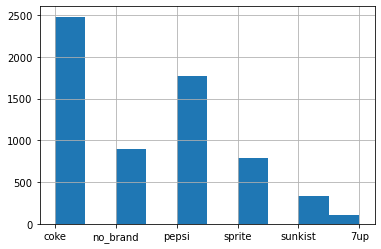

In [148]:
labelled_data['brand'].fillna('no_brand').hist()

## Prepare for training

Now that the data is labelled with which word in the document is the brand, it can now be prepared for training.

Since the product names are quite short, a character-level embedding could be effective.

## Conclusion

When dealing with biased data, look to reduce correlation between features and implement regularization.

For Named Entity Recognition and Information Extraction, labelled data is required for the model to learn how to recognize brands. Transfer learning can be useful if a pre-trained model exists for the use case. Otherwise, regular expressions can quickly label samples of clean data for use in training the initial model.